In [1]:
import warnings
import numpy as np
import pandas as pd
import catboost as catb
import lightgbm as lgbm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
# Генерация новых признаков путем умножения и деления и вывод наиболее корелирующих с целевой переменной
def feature_generation(df, TARGET_NAME, lo_limit=-0.15, hi_limit=0.15, plot_cor=False):  
    
    # Подфункция проверки уровня корреляции и добавления в массив
    def add_hi_cor_feature(col_name, col_values):
        cor = df[[TARGET_NAME]].corrwith(other=col_values)[0]
        if (cor >= hi_limit) or (cor <= lo_limit):
            df_tmp[col_name] = col_values
            df_tmp[col_name] = df_tmp[col_name].fillna(np.mean(col_values))
    
    df_tmp=df.drop(columns=TARGET_NAME).copy()
    num_col_lst = df_tmp.columns
    
    for i in range(len(num_col_lst)):
        for j in range(len(num_col_lst)):

            # Проверка уровня корреляции результатов деления признаков
            if i != j:
                col_name = num_col_lst[j] +' / '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] / df[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values)
            
            # Проверка уровня корреляции результатов умножения признаков
            if j >=i:
                col_name = num_col_lst[j] +' * '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] * df[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values)
    
    if plot_cor:
        cor = df_tmp.drop(columns=num_col_lst).corrwith(other=df[TARGET_NAME]).sort_values()
        plt.figure(figsize=(15, cor.shape[0]*0.4))
        sns.barplot(x=cor, y=cor.index)
        plt.title('Correlation with target variable')
        plt.show();
    
    df_tmp[TARGET_NAME] = df[TARGET_NAME]
    
    return df_tmp

In [4]:
def categorization_comparison_by_target_class(df, TARGET_NAME, column, sort_by='class', max_len=50):
    df_tmp = df.copy()
    #col_lst = df_tmp.drop([TARGET_NAME], axis=1).select_dtypes(include=['object']).columns
    col_lst = [column]
    
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_size_inches (20, min(df[column].nunique(), max_len)*0.5)
    plt.subplots_adjust(wspace=0.3)
    ax = ax.flatten()
    ax[1].remove()
    ax[0] = plt.subplot2grid((1,3), (0,0), colspan=2)
    
    for i in range(1):
        col = col_lst[i]
        data = df_tmp.groupby(by=col).agg({TARGET_NAME: [sum, len]})
        data['1'] = data[(TARGET_NAME, 'sum')]
        data['ttl'] = data[(TARGET_NAME, 'len')]
        data['1%'] =  data['1'] / data['ttl']
        data['0%'] =  1 - data['1%']
        data['weight'] = data['ttl'] / df_tmp.shape[0]
        if sort_by=='class':
            data = data.sort_values(by=['1%'])
        elif sort_by=='weight':
            data = data.sort_values(by=['weight'])
        elif sort_by=='label':  
            data = data.sort_index()
        
        data = data.iloc[max(data.shape[0] - max_len,0):,:]
        
        ax[0].barh(range(data.shape[0]), data['0%'], label='0')
        ax[0].barh(range(data.shape[0]), data['1%'], label='1', left=data['0%'])    
        ax[0].set_xlabel('Portion of class, %')
        ax[0].set_title('Target distribution by "' + col + '"')
        ax[0].set_xticks(np.linspace(0, 1, 11))
        
        ax[0].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['1%'] * 100, 1)).astype('str') + '%\n' + data.index.astype('str')
        ax[0].set_yticklabels(y_ticks)

        ax[0].legend(title=TARGET_NAME)
        ax[0].axvline(df_tmp.loc[df_tmp[TARGET_NAME]==0].shape[0] / df_tmp.shape[0], c='r')
        
        ax[2].barh(range(data.shape[0]), round(data['ttl'] / df_tmp.shape[0] * 100, 1), label='Weight', height=0.8)
        ax[2].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['ttl'] / df_tmp.shape[0] * 100, 1)).astype('str') + '% - ' + data['ttl'].astype('str') + '\n' + data.index.astype('str')
        ax[2].axvline(100/ df_tmp[column].nunique(), c='r')
        ax[2].set_yticklabels(y_ticks)
        ax[2].legend()

In [5]:
def distribution_comparison_by_target_class(df, TARGET_NAME):
    
    ci =95 # confidense interval
    col_lst = list(df.drop(columns=TARGET_NAME).select_dtypes(include=['float64']).columns)

    fig, ax = plt.subplots(nrows=len(col_lst), ncols=3)
    
    fig.set_size_inches (21 , len(col_lst) * 5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        sns.kdeplot(df.loc[df[TARGET_NAME] == 0, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax[i*3])
        sns.kdeplot(df.loc[df[TARGET_NAME] == 1, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax[i*3])
        ax[i*3].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
        ax[i*3].legend()
        
        sns.pointplot(x=TARGET_NAME, y=col_lst[i], data=df[[TARGET_NAME, col_lst[i]]], capsize=.1, ci=ci, ax=ax[i*3+1]);
        ax[i*3+1].set_title('Confidence intervals ('+ str(ci) + ' %) for ' + col_lst[i])
        
        cor = np.abs(df.corr()[col_lst[i]]).sort_values(ascending=False)[1:]
        sns.barplot(x=cor[:6], y=cor.index[:6], ax=ax[i*3+2])
        ax[i*3+2].set_title('Top cor features (abs)')

In [6]:
def balance_df_by_target(df, TARGET_NAME, portion_of_target_class=0.5, random_state=17):
    df_tmp = df.copy()
    counts_0 = (df_tmp[TARGET_NAME] == 0).sum()
    counts_1 = (df_tmp[TARGET_NAME] == 1).sum()
    
    if portion_of_target_class > (counts_1 / (df.shape[0])):
        disbalance = int(counts_0 / (1-portion_of_target_class) - df.shape[0])
        add_class = 1
    else:
        disbalance = int(counts_1 / portion_of_target_class - df.shape[0])
        add_class = 0
    
    sample = df_tmp[df_tmp[TARGET_NAME] == add_class].sample(n=disbalance, replace=True, random_state=random_state)

    return pd.concat([sample, df_tmp], axis=0)

In [7]:
def short_model_score_report(y_true, y_pred, y_pred_proba, name, header=False):
    f1 = round(f1_score(y_true, y_pred),4)
    pr = round(precision_score(y_true, y_pred),4)
    re = round(recall_score(y_true, y_pred),4)
    roc = round(roc_auc_score(y_true, y_pred_proba),4)
    if header:
        print('{:<20}{:>12}{:>17}{:>17}{:>17}'.format('Model', 'f1 score', 'Recall', 'Precission', 'ROC AUC'))
        print('_' * 83)
    print('{:<20}{:>12}{:>17}{:>17}{:>17}'.format(name, f1, re, pr, roc))

In [8]:
#Информация по массиву
def describe_plus(df):
    lst = np.array([[df[col].dtype, df[col].nunique()] for col in df.columns]).T
    stat = pd.DataFrame(df.describe())
    stat.loc['type'] = lst[0]
    stat.loc['NUnique'] = lst[1]
    return stat

In [9]:
def heatmap(df, cor=0):
    plt.figure(figsize = (25,20))
    sns.set(font_scale=1.4)
    sns.heatmap(df.loc[df.corr[:,-1]>cor].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

In [10]:
def scorista_report(y_true, y_proba, TARGET_NAME):
    report = pd.DataFrame({'Score': 1000-np.round(y_proba*1000,0).astype('int'),
                           TARGET_NAME: y_true})
    score_bins=[0, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 1001]
    report['Score_bin'] = pd.cut(report['Score'], right=False, bins=score_bins).astype('str')    
    report.loc[report['Score_bin']=='[800, 1001)', 'Score_bin'] = '[800, 1000]'
    report = report.sort_values(by='Score')
    
    report = report.groupby(by='Score_bin').agg({'Score':len,  TARGET_NAME:sum}).reset_index()
    report.columns = ['Score_bin', 'Qty', 'Status=1 qty', ]
    
    report['bin_weight, %'] = report['Qty'] / y_proba.shape[0] *100
    report['Status=1, portion in bin %'] = report['Status=1 qty'] / report['Qty'] *100
    report = report.sort_index(ascending=False)

    report['bin_weight cum, %'] = np.cumsum(report['bin_weight, %'])
    report['Status=1, portion cum %'] = np.cumsum(report['Status=1 qty']) /  np.cumsum(report['Qty'])* 100
    
    for col in ['bin_weight, %', 'Status=1, portion in bin %', 'bin_weight cum, %', 'Status=1, portion cum %']:
        report[col] = np.round(report[col],2).astype('str') + ' %'
    
    report = report[['Score_bin', 'Qty', 'bin_weight, %', 'bin_weight cum, %', 'Status=1 qty', 'Status=1, portion in bin %', 'Status=1, portion cum %']]
    report.columns = ['Score_bin', 'Qty', 'bin_weight, %', 'bin_weight cum, %', 'Status=1 qty', 'Status=1, portion in bin %', 'Status=1, portion cum %']
    report = report.sort_index()
    report.set_index('Score_bin',inplace=True)
    

    xy=[]
    
    for p in np.linspace(0,1,101):
        y_pred = (y_proba > p).astype('int')
        tp = np.sum((y_true == 1) & (y_true == y_pred))
        tn = np.sum((y_true == 0) & (y_true == y_pred))
        fp = np.sum((y_true == 0) & (y_true != y_pred))
        fn = np.sum((y_true == 1) & (y_true != y_pred))
        Sensitivity = tp / (tp + fn) # Чувствительность (TPR) 
        Specificity = tn / (tn + fp) # Специфичность
        xy.append([1- Specificity, Sensitivity])
    xy = np.array(xy)
    xy.sort()
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches (11.7 , 5)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.flatten()
    
    ax[0].plot(xy[:,0], xy[:,1], label='CumBads%')
    ax[0].plot([0,1], [0,1], label='Random')
    ax[0].set_title('Roc-кривая для тестовой выборки*')
    ax[0].set_xlabel('1-Специфичность')
    ax[0].set_ylabel('Чувствительность')
    ax[0].legend()
    
    ax[1].plot(xy[:,0], xy[:,1], label='CumBads%')
    ax[1].plot([0,1], [0,1], label='Random')
    ax[1].set_title('Roc-кривая для валидационной выборки*')
    ax[1].set_xlabel('1-Специфичность')
    ax[1].set_ylabel('Чувствительность')
    ax[1].legend()
    
    roc_train = round(roc_auc_score(y_true, y_proba), 4)
    roc_valid = round(roc_auc_score(y_true, y_proba), 4)
    gini_train = round(roc_train * 2 - 1, 4)
    gini_valid = round(roc_valid * 2 - 1, 4)
    
    print(('{:<15}{:<12}' + ' '*30 + '{:<15}{:<10}').format('ROC AUC train: ', roc_train,'ROC AUC Valid: ', roc_valid))
    print(('{:<15}{:<12}' + ' '*30 + '{:<15}{:<10}').format('Gini train: ', gini_train,'Gini Valid: ', gini_valid))
    
    print('\n*Валидационная и тестовая выборки совпадают т.к. модель учится на базе K-Folds \nпредсказания строится для отложеного фолда')
    
    return report

In [11]:
#Выбрал в качестве базовых моделей KNN, LR, RF, т.к. они показывают результат не хуже мощных catb xgb а работают значительно быстрее

def check_data(df=[],                    # датасет
               df_test=[],               # датасет для которого нужно сформировать предсказания
               TARGET_NAME='',  # Имя столбца с целевой переменной
               target_class_ratio=0.5,   # коэффициент для балансровки соотношения классов целевой переменной
               Random_State=42,          # Random_State
               SKF_splits=4,             # кол-во фолдов для валидации
               fold_report=True,         # вывод репорта для каждого фолда
               data_pr=True):            # Обработка данных перед построением модели          
    
    knn = KNeighborsClassifier(p=2, n_neighbors=100)
    rf = RandomForestClassifier(n_estimators=500 , random_state=42, min_samples_leaf=5)
    lr = LogisticRegression()
    
    models = {'knn': knn, 'rfm': rf, 'lrm': lr}
    #models = {'knn': knn, 'lrm': lr}
    # Список для сохранения натранированных моеделей
    model_list = []
    
    # Формирование датасетов для записи результатом работы моделей
    df_result = pd.DataFrame({'index': df.index, TARGET_NAME: df[TARGET_NAME]})
    df_test_result = pd.DataFrame({'index': df_test.index})
    
    for i in models.keys():
        df_result[i], df_result[i + '_p'] = float("NaN"), float("NaN")
        df_test_result[i], df_test_result[i + '_p'] = np.zeros(df_test.shape[0]), np.zeros(df_test.shape[0])

    #Обработка данных функцией и выстраивание одинаковой очередности колонок (на всякий случай)
    if data_pr:
        df_processed = data_processing(df, df)
        df_test_processed = data_processing(df_test, df)[df_processed.drop(columns=[TARGET_NAME]).columns]
    else:
        df_processed = df.copy()
        df_test_processed = df_test.copy()
    
    # Нормирование данных для моделей (критично для линейных моделей)
    mms_cols= df_processed.drop(columns=TARGET_NAME).columns
    mms = MinMaxScaler()
    mms.fit(df_processed[mms_cols])
    df_processed[mms_cols] = mms.transform(df_processed[mms_cols])
    df_test_processed = mms.transform(df_test_processed)
    
    #Разбивка на test и train 
    split = 0
    kf = StratifiedKFold(n_splits=SKF_splits, shuffle=True, random_state=42)
 
    for train_index, valid_index in kf.split(df_processed, df_processed[TARGET_NAME]):
        split += 1

        X_valid = df_processed.loc[valid_index].drop(columns=TARGET_NAME)
        y_valid = df_processed.loc[valid_index][TARGET_NAME]

        #Балансировка по целевому классу
        df_processed_train_balanced = balance_df_by_target(df_processed.loc[train_index], TARGET_NAME, target_class_ratio, 21)

        X_train = df_processed_train_balanced.drop(columns=TARGET_NAME)
        y_train = df_processed_train_balanced[TARGET_NAME]

        #Тренировка моделей
        if fold_report:
            print('\nFOLD ' + str(split) + ' REPORT')
        
        for i in models.keys():
                        
            models[i].fit(X_train, y_train)
            
            model_list.append([i, split, models[i]])
            
            y_valid_pred = models[i].predict(X_valid).astype('int')
            #y_train_pred = models[i].predict(X_train).astype('int')
            y_valid_pred_proba = models[i].predict_proba(X_valid)[:,1]
            #y_train_pred_proba = models[i].predict_proba(X_train)[:,1]
            
            # Запись предсказаний моделей
            df_result.loc[valid_index, i] = y_valid_pred
            df_result.loc[valid_index, i + '_p'] = y_valid_pred_proba
            df_test_result[i] += models[i].predict(df_test_processed).astype('int')
            df_test_result[i + '_p'] += models[i].predict_proba(df_test_processed)[:,1]
            
            header = True if (i == list(models.keys())[0]) else False
            if fold_report:
                short_model_score_report(y_valid, y_valid_pred, y_valid_pred_proba, i + '_' +str(split) + '_valid', header=header)
                #short_model_score_report(y_train, y_train_pred, y_train_pred_proba, len(i + '_' +str(split)) * ' ' + 'train')

    df_test_result.loc[:,'knn':'lrm'] = df_test_result.loc[:,'knn':'lrm'] / SKF_splits 

    print('\nFINAL REPORT ({}  folds) \n'.format(SKF_splits))
    for i in models.keys():
        header = True if (i == list(models.keys())[0]) else False
        short_model_score_report(df_result[TARGET_NAME], df_result[i], df_result[i+'_p'], i, header=header)
    
    y_valid = df[TARGET_NAME]
    y_valid_pred_proba = np.sum(df_result[[i + '_p' for i in models.keys()]],axis=1) / len(models.keys())
    y_valid_pred = np.round(y_valid_pred_proba).astype(int)
    short_model_score_report(y_valid, y_valid_pred, y_valid_pred_proba,'MIX RESULT ')
    
    return df_result, df_test_result, model_list

In [12]:
# Преобразование в ортагональные вектора со снижением размерности пространства признаков до заданного N
def pca_compact (df=[], TARGET_NAME=False, N=1, keep_all_columns=False, prefix=''):
    
    tmp_df = df.copy()
    
    if TARGET_NAME:
        X = tmp_df.drop(columns=TARGET_NAME)
    else:
        X = tmp_df
    
    pca = decomposition.PCA(n_components=N)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    for i in range(X_pca.shape[1]):
        tmp_df['PCA_'+ prefix + str(i+1)] = X_pca[:,i].T
    
    if not keep_all_columns:
        if TARGET_NAME:
            tmp_df.drop(columns=df.drop(columns=TARGET_NAME).columns, inplace=True)
        else:
            tmp_df.drop(columns=df.columns, inplace=True)
       
    return tmp_df

-

-

-

-

-

-

In [13]:
PATH_TO_DATA = 'D:/Personal/Lesha/Работа/Предложения/scorista/'
# input data
ds_path = PATH_TO_DATA + 'train_data.csv'
# output
output_ds_path = PATH_TO_DATA + 'predictions.csv'

# Загрузка данных
df = pd.read_csv(ds_path, ';')
TARGET_NAME = "STATUS"

In [14]:
#Информация по массиву
describe_plus(df)

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Factor_8,Factor_9,Factor_10,Factor_11,Factor_12,Factor_13,Factor_14,Factor_15,Factor_16,Factor_17,Factor_18,Factor_19,Factor_20,Factor_21,Factor_22,Factor_23,Factor_24,Factor_25,Factor_26,Factor_27,Factor_28,Factor_29,Factor_30,Factor_31,Factor_32,Factor_33,Factor_34,Factor_35,Factor_36,Factor_37,Factor_38,Factor_39,Factor_40,Factor_41,Factor_42,Factor_43,Factor_44,Factor_45,Factor_46,Factor_47,Factor_48,Factor_49,Factor_50,Factor_51,Factor_52,Factor_53,Factor_54,Factor_55,Factor_56,Factor_57,Factor_58,Factor_59,Factor_60,Factor_61,Factor_62,Factor_63,Factor_64,Factor_65,Factor_66,Factor_67,Factor_68,Factor_69,Factor_70,Factor_71,Factor_72,Factor_73,Factor_74,Factor_75,STATUS
count,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394,6394
mean,0.630109,0.453784,0.774382,273590,2.73147,1.18971,8975.24,240747,121143,3.22193,0.445014,59.4044,292.62,4.21942,35.3109,72.2552,0.585317,0.504799,51.1063,0.445014,0.315485,0.445476,0.407122,0.499364,1.83359,0.60689,35271.4,514.831,0.355812,36.0319,0.569892,634963,197.808,0.42685,5.78983,5.43056,4579.83,7.06678,21.4279,8.73944,100646,13.53,7.87885,0.333183,50260.3,6.66569,7.92024,6.4454,19.2082,2.35956,129000,0.244899,563655,1429.6,4.40773,1.43141,0.49558,0.310432,0.991242,0.39549,0.345137,0.299629,150607,0.0817839,64928.6,0.680013,0.0959634,0.34823,410.214,0.0678323,0.553331,1.14842,0.728495,0.271505,0.553331,0.322646
std,0.292184,0.278495,0.257964,950545,4.52741,1.62039,36806.7,699952,682394,5.52174,0.403895,82.8399,648.123,7.37076,57.7262,94.6037,0.451345,0.42485,81.7159,0.308804,0.359829,0.423958,0.404793,0.414442,3.06494,0.427118,128299,864.61,0.381331,50.7873,0.435048,1.48888e+06,520.945,0.392706,8.58789,9.53402,11436.3,12.2462,20.5728,12.9853,280994,14.2107,9.26009,0.356632,99642.4,6.71354,13.9648,6.39512,19.8695,3.01398,246149,0.319766,1.4244e+06,8048.42,7.07074,73.3824,0.378012,0.330655,1.69658,0.397898,0.328196,0.398454,338526,0.182786,116983,1.19014,0.187553,0.545786,768.084,0.1514,1.59197,3.41952,1.80881,1.0073,1.59197,0.467525
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,0.5,0.214286,0.666667,3070.25,0,0,0,5000,2600.25,0,0,6,8,0,2,10,0,0,2,0.2,0,0,0,0,0,0,1942.49,8,0,3,0,38971,2,0,0.25,1,0,1,5,2,4000,2,1,0,8047.94,1.28571,0,1.85179,3,0,7161.75,0,15953.5,0,0,0,0,0,0,0,0.0203762,0,10000,0,10010.2,0,0,0,13,0.002064,0,0,0,0,0,0
50%,0.666667,0.454716,0.848485,41770.5,1,0.777778,3304.29,47000,20379,1,0.422065,28,19,2,13,38,0.8,0.5,19,0.466667,0.194783,0.5,0.363636,0.5,1,0.8,10577.4,30,0.25,16,0.705882,186954,12,0.5,2.48077,2,1174.08,3,15,4.5,20998.5,9,5,0.25,21692.1,5.26136,2,4.7,12,1,44299,0,136554,0,2,0,0.5,0.214286,0,0.333333,0.259259,0,50000,0,30953.8,0,0,0.142857,42,0.011111,0,0,0,0,0,0
75%,0.857143,0.690931,1,216370,3,1.55556,10029.2,211991,82043.5,4,0.875,81.75,166.75,5,45,98,1,1,67,0.666667,0.5,1,0.777778,1,2,1,29763.6,740,0.666667,50,1,610542,35,0.777778,8,6,6324.67,8,34,10,80000,21,11.3333,0.571429,52626.8,9.90682,10,9.14286,30,4,149046,0.444444,523602,0,6,0.0227045,0.833333,0.5,1,0.75,0.571429,0.595532,148235,0.083333,74638.9,1,0.125,0.5,372,0.055046,0,0,1,0,0,1
max,1,1,1,4.29756e+07,52,12,1.79079e+06,3.053e+07,4.24155e+07,72,1,1321,4481,117,1130,1349,1,1,1553,1,1,1,1,1,37,1,5.37237e+06,4518,1,488,1,4.31385e+07,4481,1,103,150,478923,198,131,198,7.62e+06,106,88,1,2.4796e+06,77,200,81,131,13,4.59072e+06,1,4.3061e+07,367740,117,4981,1,1,20,1,1,1,6e+06,1,3.5e+06,16,1,11,4571,1,29,93,24,15,29,1
type,float64,float64,float64,int64,int64,float64,float64,int64,int64,int64,float64,int64,in

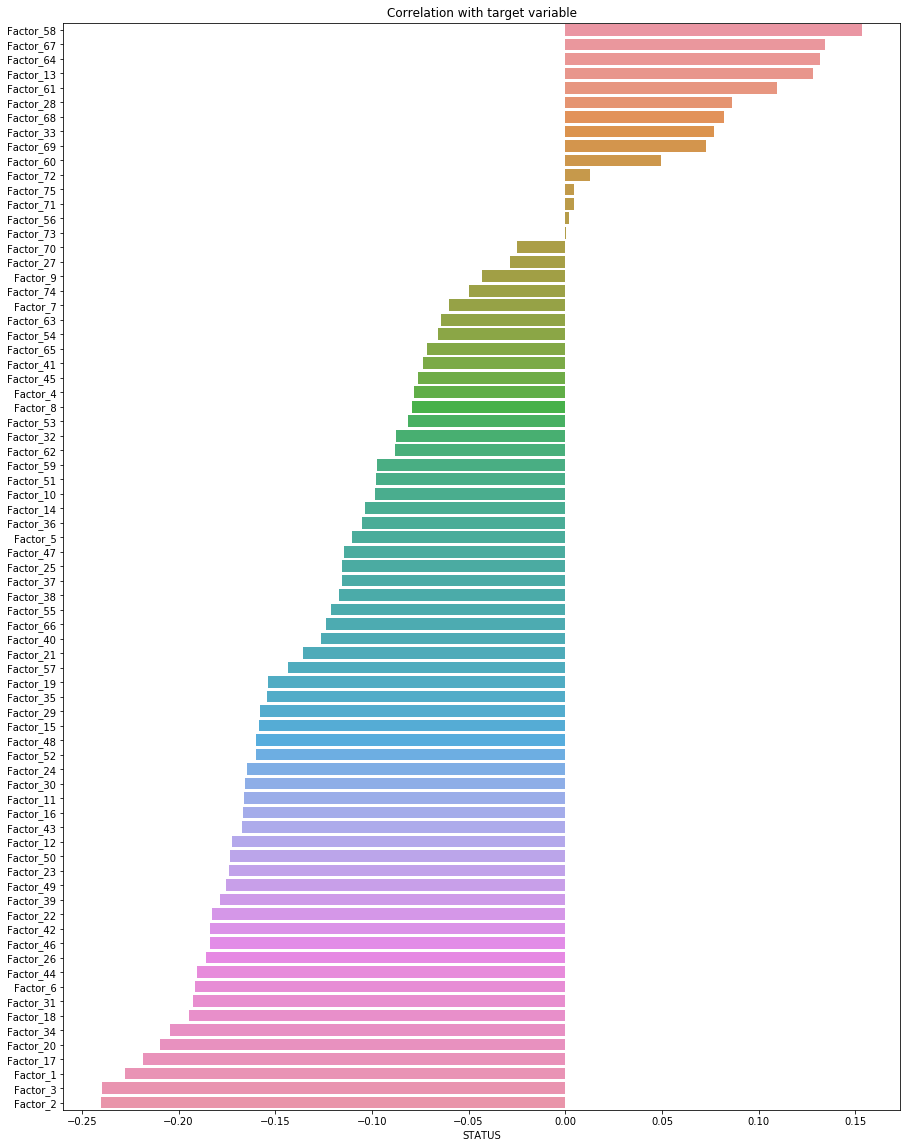

In [15]:
#Кореляция факторов с целевой переменной
cor = df.corr().iloc[:-1,-1].sort_values(ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x=cor, y=cor.index)
plt.title('Correlation with target variable')
plt.show();

#pointbiserialr correlation
#col_list = df.columns
#pb_cor = []
#for i in range(len(col_list)):
#    pb_cor.append([col_list[i], stats.pointbiserialr(df[TARGET_NAME], df[col_list[i]])[0]])

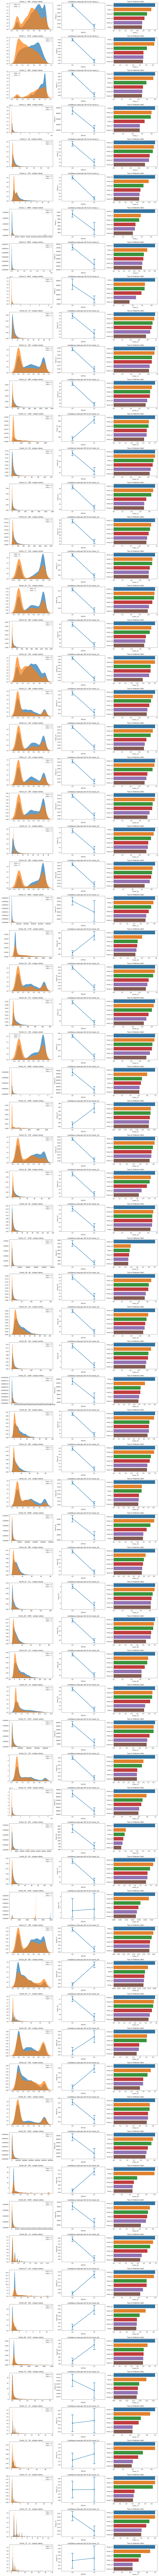

In [16]:
# Визуальный анализ данных
#1) Вывод плотности распределения, 
#2) оценка среднего значения с уровнем значимости 0.05
#3) Скорелированные факторы
distribution_comparison_by_target_class(df[df.columns].astype('float64'),TARGET_NAME)

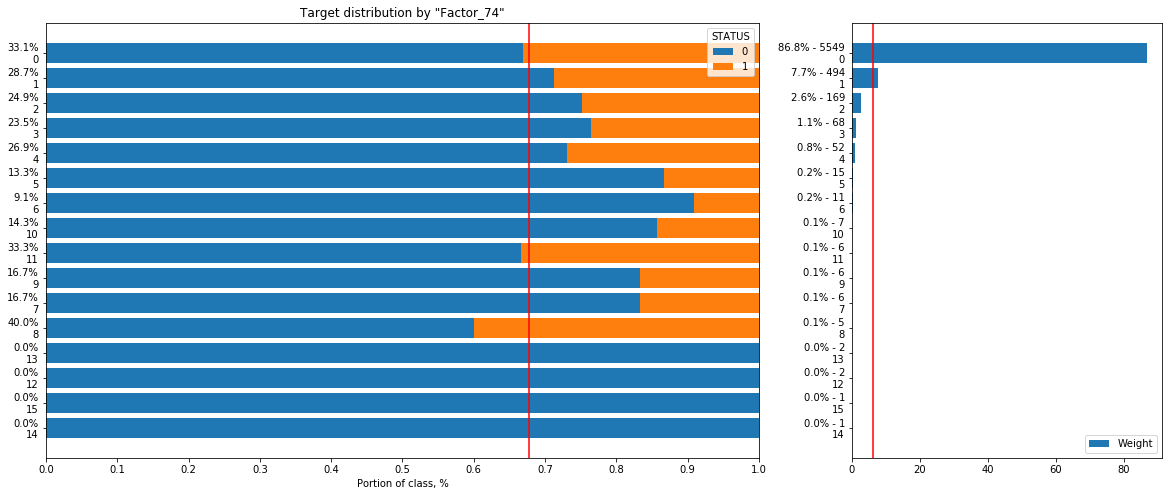

In [17]:
#Визуальная роверка разделения классов по категриямь для категориальных данных
categorization_comparison_by_target_class(df, TARGET_NAME, 'Factor_74', sort_by='weight')

# Основные Выводы из визуального анализа

1) Необходимо провести чистку для приpнаков с длинными хвостами а также проверить результат работы моедли после логорифмирования, отсечения выбросов и других базовых манипуляций

2) Средние значения выборок разбитых на классы в доверительном диапазоне 95% для большей части признаков сильно отличаются но при этом много признаков скорелированы

3) Значение кореляции каждого фактора по отдельности с целевой переменной небольшое, но при этом наблюдается большое кол-во высокоскоррелировнных признаков (0.7-1)
Необходимо проверить возможность снижения размерности пространства признаков с помощью PCA без потери качества работы модели

В зависимости от задачи можно будет выбрать что приоритетнее более низкоее кол-во факторов и скорост работы модели или более высоко качество моедли

4) Необходимо провреить скоррелированные с целевой переменной комбинации нелинейных признаков

In [18]:
# Функция обработки данных
def data_processing(df, df_for_stat):
    
    #функция для чистки выбросов по интерквартильному размаху
    def clean_drop_outs(col, stat_col, span):
        max_col_value = stat_col.quantile(q=0.75) + (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        min_col_value = stat_col.quantile(q=0.25) - (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        col.loc[(col > max_col_value) | (col < min_col_value)] = stat_col.mean()    
    
    def replace_zeros(col, function):
        tmp_df.loc[tmp_df[col]==0, col] = function(tmp_df.loc[tmp_df[col]!=0, col])
    
    tmp_df = df.copy()
    stat_df = df_for_stat.copy()  
    
    #Замена нулей на центральные тенденции
    #replace_zeros('Factor_2', np.mean)
    
    #Преобразование типов
    tmp_df[tmp_df.columns] = tmp_df[tmp_df.columns].astype('float')

    # Дополнительные признаки практически не дали результата
    #tmp_df['F2*F3'] = tmp_df['Factor_2'] * tmp_df['Factor_3'] # -
    #tmp_df['F34*F35'] = tmp_df['Factor_34'] * tmp_df['Factor_35'] # -
    #tmp_df['F17*F16'] = tmp_df['Factor_17'] * tmp_df['Factor_16'] # -
    #tmp_df['F62/F60'] = (tmp_df['Factor_62'] / tmp_df['Factor_60']).fillna(0) # +/-
    #tmp_df['F39/F16'] = (tmp_df['Factor_39'] / tmp_df['Factor_16']).fillna(0) # + 
    #tmp_df['F49/F12'] = (tmp_df['Factor_49'] / tmp_df['Factor_12']).fillna(0) # - 
    #tmp_df['F17*F1'] = tmp_df['Factor_17'] * tmp_df['Factor_1'] # -
    #tmp_df['F61*F58'] = tmp_df['Factor_61'] * tmp_df['Factor_58'] # +/-
    #tmp_df['F20*F3'] = tmp_df['Factor_20'] * tmp_df['Factor_3'] # +/-
    #tmp_df['F17*F3'] = tmp_df['Factor_17'] * tmp_df['Factor_3'] # -
    #tmp_df['F17*F44'] = tmp_df['Factor_44'] * tmp_df['Factor_17'] # -
    
    #replace_zeros('F1*F2', np.mean)

    
    #Обработка кластера 'F5_F10_F14_F36' 
    tmp_df['Factor_5=0'] = tmp_df['Factor_5']==0
    tmp_df.drop(columns=['Factor_10', 'Factor_14'], inplace=True)

    
    # Обработка кластера 'F13_F28_F69'
    tmp_df.loc[tmp_df['Factor_28']==0, 'Factor_28'] = tmp_df.loc[tmp_df['Factor_28']==0, 'Factor_13']
    tmp_df.loc[tmp_df['Factor_28']==0, 'Factor_28'] = tmp_df.loc[tmp_df['Factor_28']==0, 'Factor_69']
    tmp_df['Factor_28'] = (tmp_df['Factor_28'] + tmp_df['Factor_13']* 9)/10
    tmp_df.drop(columns=['Factor_13'], inplace=True)
    
    
    # Обработка кластера 'F32_F53'
    tmp_df.loc[tmp_df['Factor_32']==0, 'Factor_32'] = tmp_df.loc[tmp_df['Factor_32']==0, 'Factor_53']
    tmp_df.drop(columns=['Factor_53'], inplace=True)

    
    # Обработка кластера 'F12_F15_F16_F19_F30'
    # Добавление пропущенных значения
    tmp_df.loc[tmp_df['Factor_12']==0, 'Factor_12'] = tmp_df.loc[tmp_df['Factor_12']==0, 'Factor_16']
    tmp_df['Factor_12'] = tmp_df['Factor_12'] + tmp_df['Factor_30']
    # PCA преобразование для снижения размерности удаления лишнеих факторов
    compact_col_lst = ['Factor_12', 'Factor_15', 'Factor_16', 'Factor_19', 'Factor_30']
    pca_df = pca_compact(df=tmp_df[compact_col_lst], N=1, TARGET_NAME=False, keep_all_columns=False)
    tmp_df['Factor_12_PCA'] = pca_df
    tmp_df.drop(columns=compact_col_lst, inplace=True)
    
    
    # Обработка кластера 'F38_F39_F40_F42_F49' - не принесла результата
    
    # Логорифмирование (а также извелечение корней) - не принесла ощулимого результата
    #for col in ['Factor_6']:
    #    tmp_df[col] = np.log((tmp_df[col] - np.min(stat_df[col]) + 1e-10)) / np.max(stat_df[col])
    
    # Разворот и логорифмирование - незачительное улучшение ROC AUC, с ухудшением остальных KPI
    for col in ['Factor_3']:
        tmp_df[col] = np.log(np.max(stat_df[col]) - tmp_df[col] + 1)
    
    # Замена категориальной переменной на частоту ее появления
    tmp_df['Factor_5'] = tmp_df['Factor_5'].map(dict(stat_df['Factor_5'].value_counts() / len(stat_df['Factor_5']))) ** 0.5
    tmp_df['Factor_7'] = tmp_df['Factor_7'].map(dict(stat_df['Factor_7'].value_counts() / len(stat_df['Factor_7']))) ** 0.5
    tmp_df['Factor_20'] = tmp_df['Factor_20'].map(dict(stat_df['Factor_20'].value_counts() / len(stat_df['Factor_20']))) ** 0.5

    # Чистка выбросов на базе инерквартильного размаха - результат только для 4-го признака
    clean_drop_outs(tmp_df['Factor_4'], stat_df['Factor_4'], span=2)
    
    # Преобразования в dummy переменные для категориальных признаков ухудшило работы модели

    # PCA преобразование для снижения размерности - в целом ухудшает результат хотя и позволяет сократить кол-во принаков в разы
    #compact_col_lst = ['Factor_12', 'Factor_15', 'Factor_16', 'Factor_19']
    #pca_df = pca_compact(df=tmp_df[compact_col_lst], N=1, TARGET_NAME=False, keep_all_columns=False)
    #for i in range(pca_df.shape[1]):
    #    tmp_df['PCA_1_' + str(i+1)] = pca_df['PCA_' + str(i+1)]
    #tmp_df.drop(columns=compact_col_lst, inplace=True)
    
    return tmp_df

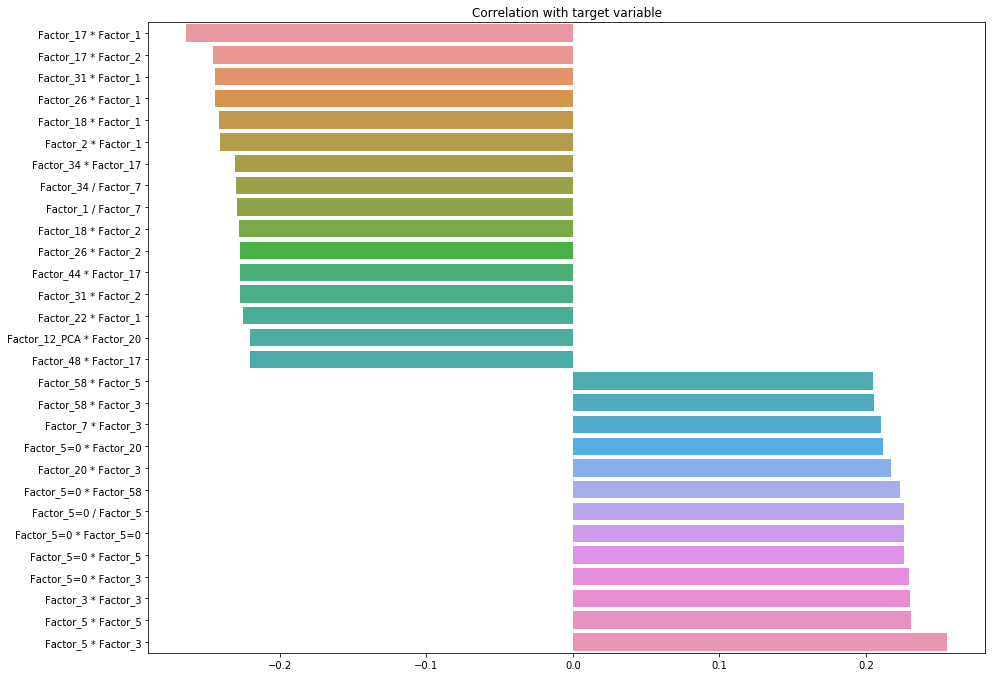


FINAL REPORT (5  folds) 

Model                   f1 score           Recall       Precission          ROC AUC
___________________________________________________________________________________
knn                        0.539           0.6321           0.4697            0.703
rfm                       0.5217           0.5196           0.5237           0.7235
lrm                       0.5603           0.6675           0.4828           0.7252
MIX RESULT                0.5552           0.6214           0.5018           0.7269

Wall time: 2min 21s


In [20]:
%%time
# Расчет показателей модели для случая с дополнительными признаками
# Предварительная обработка и добавление дополнительных признаков (результат умножени и деления признаков) с высокой корреляцией

df1 = data_processing(df,df)
df1 = feature_generation(df1, TARGET_NAME, lo_limit=-0.22, hi_limit = 0.2, plot_cor=True)

df_result, df_test_result, model_list = check_data(df=df1, df_test=df1.drop(columns=TARGET_NAME), TARGET_NAME=TARGET_NAME, target_class_ratio=0.50, Random_State=42, SKF_splits=5, fold_report=False, data_pr=False)
print()

In [21]:
%%time
# Расчет показателей модели для случая с базовой обработкой данных (метрики лучше)
df_result, df_test_result, model_list = check_data(df=df, df_test=df.drop(columns=TARGET_NAME), TARGET_NAME=TARGET_NAME, target_class_ratio=0.50, Random_State=42, SKF_splits=5, fold_report=False, data_pr=True)
print()


FINAL REPORT (5  folds) 

Model                   f1 score           Recall       Precission          ROC AUC
___________________________________________________________________________________
knn                       0.5405           0.6277           0.4745           0.7018
rfm                       0.5234           0.5187           0.5281           0.7259
lrm                       0.5626           0.6655           0.4872           0.7228
MIX RESULT                0.5531           0.6151           0.5024            0.728

Wall time: 1min 37s



Запись в файл: scorista_case_score.csv

ROC AUC train: 0.728                                     ROC AUC Valid: 0.728     
Gini train:    0.456                                     Gini Valid:    0.456     

*Валидационная и тестовая выборки совпадают т.к. модель учится на базе K-Folds 
предсказания строится для отложеного фолда


,Qty,"bin_weight, %","bin_weight cum, %",Status=1 qty,"Status=1, portion in bin %","Status=1, portion cum %"
Score_bin,,,,,,
"[0, 250)",345,5.4 %,100.0 %,230,66.67 %,32.26 %
"[250, 300)",342,5.35 %,94.6 %,206,60.23 %,30.3 %
"[300, 350)",405,6.33 %,89.26 %,215,53.09 %,28.51 %
"[350, 400)",421,6.58 %,82.92 %,199,47.27 %,26.63 %
"[400, 450)",443,6.93 %,76.34 %,199,44.92 %,24.85 %
"[450, 500)",564,8.82 %,69.41 %,218,38.65 %,22.85 %
"[500, 550)",568,8.88 %,60.59 %,213,37.5 %,20.55 %
"[550, 600)",631,9.87 %,51.7 %,184,29.16 %,17.63 %
"[600, 650)",594,9.29 %,41.84 %,130,21.89 %,14.92 %


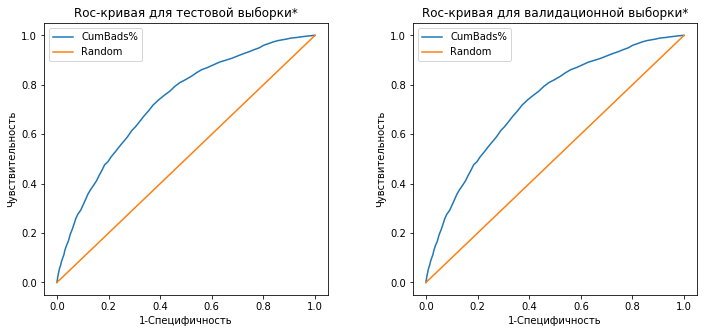

In [22]:
# Отчет в заданной форме Scorista

y_valid = df[TARGET_NAME]
y_valid_pred_proba = np.sum(df_result[['knn_p', 'rfm_p','lrm_p']],axis=1) / 3

scorista_score = 1000 - np.round(y_valid_pred_proba * 1000).astype('int')
report_path = PATH_TO_DATA + 'scorista_case_score.csv'

pd.DataFrame({'id': list(df.index),
              'Score': scorista_score}).to_csv(report_path, index=False)
print('\nЗапись в файл:', 'scorista_case_score.csv\n')

scorista_report(y_valid, y_valid_pred_proba, TARGET_NAME)

In [23]:
# Функция для преварительной быстрой проверка, какие преобразование прихнаков улучшают работу модели

# Логорифмирование
def data_processing_log(df, df_for_stat, col):
    tmp_df = df.copy()
    stat = df_for_stat.copy()
    
    tmp_df[col] = ((tmp_df[col] - np.min(stat[col])+ 1e-10)) / np.max(stat[col])
    tmp_df[col] = np.log(tmp_df[col])   
    
    return tmp_df

# Отсечение выбросов, интерквартильный размах *1.5
def data_processing_cut(df, df_for_stat, col):
    tmp_df = df.copy()
    stat = df_for_stat.copy()
    # бытсрая чистка выбросов
    max_col_value = stat[col].quantile(q=0.75) + (stat[col].quantile(q=0.75) - stat[col].quantile(q=0.25))*1.5
    min_col_value = stat[col].quantile(q=0.25) - (stat[col].quantile(q=0.75) - stat[col].quantile(q=0.25))*1.5
    tmp_df.loc[(df[col] > max_col_value) | (tmp_df[col] < min_col_value), col] = stat[col].mean()   
    
    return tmp_df

# Логорифмирование и отсечение выбросов, интерквартильный размах *1.5
def data_processing_log_cut(df, df_for_stat, col):
    tmp_df = df.copy()
    stat = df_for_stat.copy()
    
    tmp_df[col] = ((tmp_df[col] - np.min(stat[col])+ 1e-10)) / np.max(stat[col])
    tmp_df[col] = np.log(tmp_df[col])   
    
    # бытсрая чистка выбросов
    max_col_value = stat[col].quantile(q=0.75) + (stat[col].quantile(q=0.75) - stat[col].quantile(q=0.25))*1.5
    min_col_value = stat[col].quantile(q=0.25) - (stat[col].quantile(q=0.75) - stat[col].quantile(q=0.25))*1.5
    tmp_df.loc[(df[col] > max_col_value) | (tmp_df[col] < min_col_value), col] = stat[col].mean()   
    
    return tmp_df

In [24]:
%%time
# Проверка работы модели после преобразования признаков
print('БАЗОВАЯ МОДЕЛЬ')
df_result, df_test_result, model_list = check_data(df=df,
                                                    df_test=df.drop(columns=TARGET_NAME),
                                                    TARGET_NAME=TARGET_NAME,
                                                    target_class_ratio=0.50,
                                                    Random_State=42,
                                                    SKF_splits=4,
                                                    data_pr=False,
                                                    fold_report=False)


for col in df.drop(columns=TARGET_NAME).columns[:3]:
    df_processed = data_processing_log(df,df, col)
    print('\nLOG ' + col)
    df_result, df_test_result, model_list = check_data(df=df_processed,
                                                        df_test=df_processed.drop(columns=TARGET_NAME),
                                                        TARGET_NAME=TARGET_NAME,
                                                        target_class_ratio=0.50,
                                                        Random_State=42,
                                                        SKF_splits=4,
                                                        data_pr=False,
                                                        fold_report=False)
    df_processed = data_processing_cut(df,df, col)
    print('\nCUT ' + col)
    df_result, df_test_result, model_list = check_data(df=df_processed,
                                                        df_test=df_processed.drop(columns=TARGET_NAME),
                                                        TARGET_NAME=TARGET_NAME,
                                                        target_class_ratio=0.50,
                                                        Random_State=42,
                                                        SKF_splits=4,
                                                        data_pr=False,
                                                        fold_report=False)
    df_processed = data_processing_log_cut(df,df, col)
    print('\nLOG&CUT ' + col)
    df_result, df_test_result, model_list = check_data(df=df_processed,
                                                        df_test=df_processed.drop(columns=TARGET_NAME),
                                                        TARGET_NAME=TARGET_NAME,
                                                        target_class_ratio=0.50,
                                                        Random_State=42,
                                                        SKF_splits=4,
                                                        data_pr=False,
                                                        fold_report=False)

БАЗОВАЯ МОДЕЛЬ

FINAL REPORT (4  folds) 

Model                   f1 score           Recall       Precission          ROC AUC
___________________________________________________________________________________
knn                       0.5447           0.6423           0.4729           0.7018
rfm                       0.5197           0.5177           0.5217           0.7219
lrm                       0.5554            0.652           0.4838           0.7155
MIX RESULT                0.5513           0.6142           0.5002            0.724

LOG Factor_1

FINAL REPORT (4  folds) 

Model                   f1 score           Recall       Precission          ROC AUC
___________________________________________________________________________________
knn                        0.543           0.6384           0.4724           0.7021
rfm                       0.5197           0.5177           0.5217            0.722
lrm                        0.554           0.6544           0.4803           

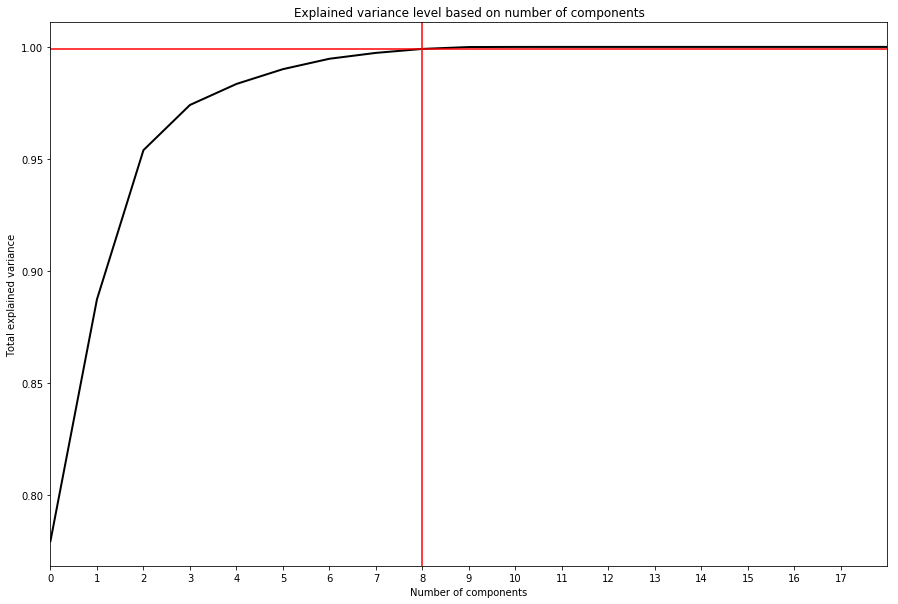

[0.77961 0.88741 0.95396 0.97411 0.98348 0.99008 0.99472 0.99734 0.99911
 0.99995 0.99999 1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.     ]


In [25]:
# Определение кол-ва признаков достаточного для построения модели с потерей порогового значения вариции
#df1 = feature_generation(df, TARGET_NAME)

num_feat = df1.drop(columns=TARGET_NAME).columns
pca = decomposition.PCA().fit(df1[num_feat])
feat_added_variannce = np.cumsum(pca.explained_variance_ratio_)


acceptable_variance_loss = 1e-3
min_fetures_qty = np.sum(feat_added_variannce<(1-acceptable_variance_loss))

print 
plt.figure(figsize=(15,10))
plt.plot(feat_added_variannce, color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, min(df1[num_feat].shape[1], min_fetures_qty + 10))
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(min(df1[num_feat].shape[1], min_fetures_qty + 10)))
plt.axvline(min_fetures_qty, c='r')
plt.axhline(1-acceptable_variance_loss, c='r')
plt.title('Explained variance level based on number of components')
plt.show();

print(feat_added_variannce.round(5))

In [26]:
%%time

# Тестирование PCA преобразование для снижения размерности - снижение размерности приводит к потере качества модели

for N in [10, 30, 60]:
    
    tmp_df = df.copy()
    tmp_df = data_processing(tmp_df,tmp_df)
    compact_col_lst = tmp_df.drop(columns=TARGET_NAME).columns
    
    pca_df = pca_compact(df=tmp_df, N=N, TARGET_NAME=TARGET_NAME, keep_all_columns=False)
    for i in range(N):
        tmp_df['PCA_' + str(i+1)] = pca_df['PCA_' + str(i+1)]
    tmp_df.drop(columns=compact_col_lst, inplace=True)
    print('\n'+ str(N), ' P COMPONENTS')
    df_result, df_test_result, model_list = check_data(df=tmp_df, df_test=tmp_df.drop(columns=TARGET_NAME), TARGET_NAME=TARGET_NAME, target_class_ratio=0.50, Random_State=42, SKF_splits=4, fold_report=False, data_pr=False)


10  P COMPONENTS

FINAL REPORT (4  folds) 

Model                   f1 score           Recall       Precission          ROC AUC
___________________________________________________________________________________
knn                       0.4931           0.5923           0.4224           0.6358
rfm                       0.4333           0.4062           0.4643           0.6348
lrm                        0.514           0.7639           0.3873            0.644
MIX RESULT                0.4828           0.5337           0.4408           0.6479

30  P COMPONENTS

FINAL REPORT (4  folds) 

Model                   f1 score           Recall       Precission          ROC AUC
___________________________________________________________________________________
knn                       0.5293           0.7038           0.4241           0.6719
rfm                       0.5005           0.4566           0.5538           0.6987
lrm                       0.5383           0.6951           0.4392    

Wall time: 58.9 s


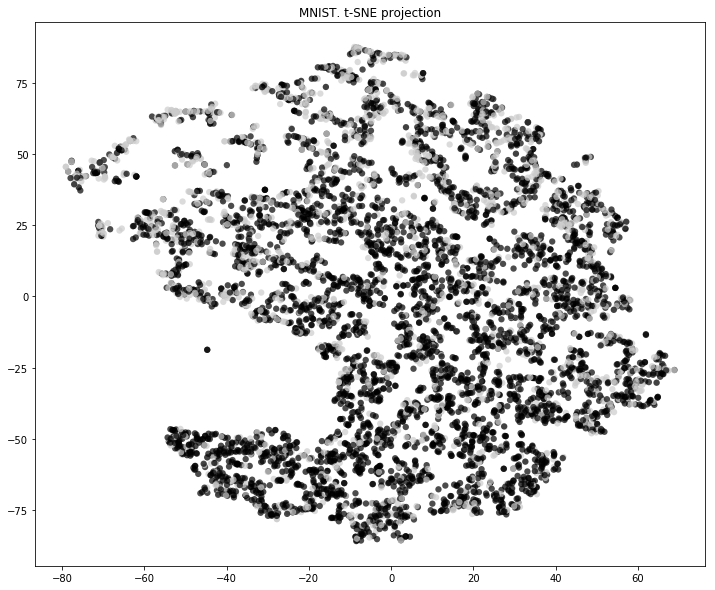

In [27]:
%%time 
#визуализация разделения на классы TSNE - не cработала

compact_col_lst = df.drop(columns=TARGET_NAME).columns

from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)

X_tsne = tsne.fit_transform(df[compact_col_lst])

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[TARGET_NAME], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
#plt.colorbar()
plt.title('MNIST. t-SNE projection')